In [66]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random
import joblib
from xgboost import XGBClassifier

Model is trained on the combination of first_batch and second_batch to predict the third_batch.

In [67]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [68]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        
        # Define the outlier range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove rows with outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']

    # Weighted scores
    df_user_features['weighted_score'] = df_user_features['count_like'] * 1.5 - df_user_features['count_dislike'] * 1.5

    # Distribution features
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # New features
    df_user_features['avg_deviation_from_popularity'] = df_X_with_popularity.groupby('user').apply(
    lambda x: np.abs(x['rating'] - x['popularity_score']).mean())

    # Drop columns with high correlation
    # Count watch has high correlation with total interactions
    df_user_features.drop(columns=['total_interactions'], inplace=True)
    df_user_features.drop(columns=['median_rating'], inplace=True)

    # Drop columns with low mutual information
    # NIL (for now)

    # If labels are provided, merge with df_y
    if df_y is not None:
        # Remove outliers
        df_user_features = remove_outliers(df_user_features, df_user_features.columns)
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        top_features = df_user_features.columns.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

In [69]:
data_first = np.load("first_second_batch_multi_labels.npz")
X_first = data_first["X"]
y_first = data_first["yy"]

# Convert to DataFrame
df_X_first = pd.DataFrame(X_first, columns=["user", "item", "rating"])
df_y_first = pd.DataFrame(y_first, columns=["user", "label"])

# Engineer features for the first dataset
df_merged_first, top_features = engineer_features(df_X_first, df_y=df_y_first)

scaler = StandardScaler()

# Features and Labels
X_features_first = df_merged_first.drop(columns=['user', 'label'])
y_labels_first = df_merged_first['label']

X_train_scaled = scaler.fit_transform(X_features_first)

# Define base logistic regression model
base_logreg = LogisticRegression(random_state=RANDOM_SEED)

# Wrap it with OneVsRestClassifier
ovr_logreg = OneVsRestClassifier(base_logreg)

# Define parameter grid for logistic regression
param_grid_logreg = {
    'estimator__C': [0.1, 1, 10, 35, 100],  # Wider range of C values
    'estimator__penalty': ['l2', 'l1'],  # Include L1 penalty
    'estimator__solver': ['newton-cg', 'lbfgs', 'saga'],  # Include saga solver
    'estimator__max_iter': [1000, 2000, 3000],  # Increased max_iter
    'estimator__tol': [1e-4, 1e-5, 1e-6],  # Adjusted tolerance levels
    'estimator__warm_start': [True, False],
}

# Initialize RandomizedSearchCV for logistic regression
random_search_logreg = RandomizedSearchCV(
    estimator=ovr_logreg, 
    param_distributions=param_grid_logreg, 
    # Increase to 100 will marginally improve the results
    n_iter=10,
    scoring='roc_auc_ovr',
    cv=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Fit RandomizedSearchCV to the training data (first dataset)
random_search_logreg.fit(X_train_scaled, y_labels_first)

# Print the best parameters found by RandomizedSearchCV
print(f"Best Parameters (Logistic Regression): {random_search_logreg.best_params_}")

# Use the best logistic regression model from RandomizedSearchCV
best_logreg_model = random_search_logreg.best_estimator_
model = best_logreg_model

C:\Users\teoju\AppData\Local\Temp\ipykernel_30876\212894115.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_user_features['avg_deviation_from_popularity'] = df_X_with_popularity.groupby('user').apply(


Best Parameters (Logistic Regression): {'estimator__warm_start': False, 'estimator__tol': 0.0001, 'estimator__solver': 'newton-cg', 'estimator__penalty': 'l2', 'estimator__max_iter': 2000, 'estimator__C': 100}


C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
      

In [70]:
data_third

NpzFile 'third_batch_multi.npz' with keys: X

In [71]:
data_third = np.load("third_batch_multi.npz")
X_third = data_third["X"]

df_X_third = pd.DataFrame(X_third, columns=["user", "item", "rating"])

# Engineer features for the third dataset
df_merged_third = engineer_features(df_X_third, top_features)

# Scale the features
X_third_scaled = scaler.transform(df_merged_third.drop(columns=['user']))

# Predict probabilities for the third dataset
y_pred_proba_third = model.predict_proba(X_third_scaled)

# Create a DataFrame to hold user IDs and their corresponding class probabilities
df_predictions_third = pd.DataFrame({
    'user': df_merged_third['user'],
    'z0': y_pred_proba_third[:, 0],
    'z1': y_pred_proba_third[:, 1],
    'z2': y_pred_proba_third[:, 2],
    'predicted_class': np.argmax(y_pred_proba_third, axis=1)
})

df_predictions_third

C:\Users\teoju\AppData\Local\Temp\ipykernel_30876\212894115.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_user_features['avg_deviation_from_popularity'] = df_X_with_popularity.groupby('user').apply(


,user,z0,z1,z2,predicted_class
0,2200,0.061740,0.929656,0.008604,1
1,2201,0.000362,0.946300,0.053339,1
2,2202,0.000468,0.978741,0.020791,1
3,2203,0.889322,0.110298,0.000379,0
4,2204,0.448969,0.535098,0.015933,1
...,...,...,...,...,...
1035,3235,0.006570,0.917614,0.075816,1
1036,3236,0.044705,0.954596,0.000698,1
1037,3237,0.000007,0.958334,0.041658,1
1038,3238,0.006783,0.976588,0.016629,1


In [73]:
df_final = df_predictions_third.drop(['user', 'predicted_class'], axis = 'columns')
df_final

,z0,z1,z2
0,0.061740,0.929656,0.008604
1,0.000362,0.946300,0.053339
2,0.000468,0.978741,0.020791
3,0.889322,0.110298,0.000379
4,0.448969,0.535098,0.015933
...,...,...,...
1035,0.006570,0.917614,0.075816
1036,0.044705,0.954596,0.000698
1037,0.000007,0.958334,0.041658
1038,0.006783,0.976588,0.016629


In [82]:
import time
np.savez(f"./cs421-g1-team3-week10-{time.time_ns()//1_000_000}.npz", scores=df_final.to_numpy())

In [84]:
np.load('cs421-g1-team3-week10-1729649099012.npz')['scores'].shape

(1040, 3)

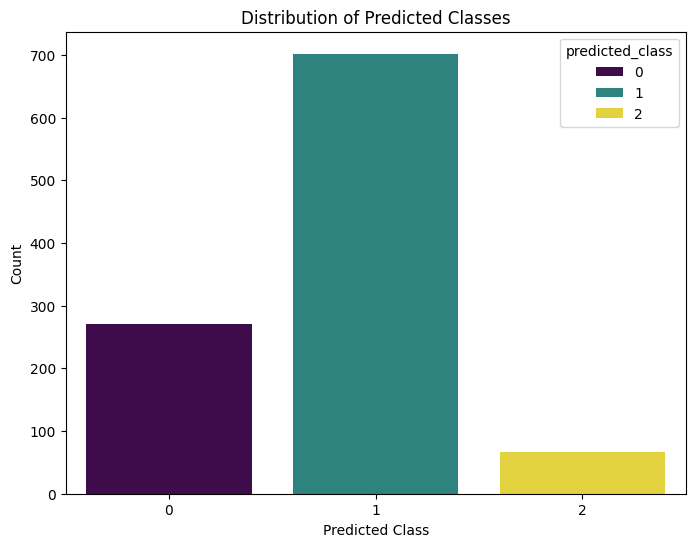

In [76]:
# Plot the distribution of predicted classes
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_class', data=df_predictions_third, palette='viridis', hue='predicted_class')

# Set plot labels and title
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Distribution of Predicted Classes')
plt.show()

In [54]:
df_predictions_third['z1'] 

,user,z0,z1,z2,predicted_class
0,2200,0.067784,0.919886,0.012330,1
1,2201,0.000541,0.935905,0.063554,1
2,2202,0.001684,0.927505,0.070810,1
3,2203,0.867079,0.132476,0.000446,0
4,2204,0.459407,0.520856,0.019737,1
...,...,...,...,...,...
1035,3235,0.006625,0.900217,0.093158,1
1036,3236,0.045461,0.952631,0.001908,1
1037,3237,0.000013,0.924614,0.075373,1
1038,3238,0.007833,0.963849,0.028318,1


In [55]:
data_first = np.load("first_second_batch_multi_labels.npz")

In [56]:
X_first = data_first["X"]
y_first = data_first["yy"]

# Convert to DataFrame
df_X_first = pd.DataFrame(X_first, columns=["user", "item", "rating"])
df_y_first = pd.DataFrame(y_first, columns=["user", "label"])

# Engineer features for the first dataset
df_merged_first, top_features = engineer_features(df_X_first, df_y=df_y_first)

C:\Users\teoju\AppData\Local\Temp\ipykernel_30876\388179390.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_user_features['avg_deviation_from_popularity'] = df_X_with_popularity.groupby('user').apply(


In [57]:
data_third = np.load("third_batch_multi.npz")
X_third = data_third["X"]

df_X_third = pd.DataFrame(X_first, columns=["user", "item", "rating"])

In [58]:
df_merged_third

,user,mean_rating,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
0,2200,2.714286,4.328935,2,11,21,57,0.262500,0.025000,0.137500,0.712500,28.5,0.599777,10.777325
1,2201,2.773723,4.144438,2,14,31,90,0.252033,0.016260,0.113821,0.731707,43.5,0.502281,11.626054
2,2202,-1.326679,4.812710,119,108,15,309,0.033860,0.268623,0.243792,0.697517,-156.0,0.156543,11.994262
3,2203,4.432203,4.663880,1,7,47,63,0.423423,0.009009,0.063063,0.567568,69.0,-1.178190,9.846201
4,2204,1.804196,5.315747,13,21,31,78,0.254098,0.106557,0.172131,0.639344,27.0,0.486347,9.250028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,3235,0.283784,4.600537,9,8,6,51,0.090909,0.136364,0.121212,0.772727,-4.5,1.778435,10.651253
1036,3236,3.105839,4.572545,6,41,76,151,0.326180,0.025751,0.175966,0.648069,105.0,-0.010370,6.959701
1037,3237,1.542029,5.023677,30,50,63,202,0.213559,0.101695,0.169492,0.684746,49.5,0.914206,9.155213
1038,3238,2.617647,3.940257,1,13,21,67,0.235955,0.011236,0.146067,0.752809,30.0,0.683127,12.825187
